In [1]:
# Load the json as WarehouseLayout object
from pathlib import Path
from adaptive_warehouse.warehouse_layout import JsonWarehouseLayoutLoader


layout_loader = JsonWarehouseLayoutLoader(Path("../demo_data/warehouse-layout.json"))
warehouse_layout = layout_loader.load()


2025-11-26 23:03:42,960 [INFO] Parsing rack face area A11 2
2025-11-26 23:03:42,961 [INFO] Parsing rack face area A12 1
2025-11-26 23:03:42,965 [INFO] Parsing rack face area A12 2
2025-11-26 23:03:42,969 [INFO] Parsing rack face area A13 1
2025-11-26 23:03:43,026 [INFO] Parsing rack face area A13 2
2025-11-26 23:03:43,030 [INFO] Parsing rack face area A14 1
2025-11-26 23:03:43,034 [INFO] Parsing rack face area A14 2
2025-11-26 23:03:43,039 [INFO] Parsing rack face area A15 1
2025-11-26 23:03:43,044 [INFO] Parsing rack face area A15 2
2025-11-26 23:03:43,052 [INFO] Parsing rack face area A16 1
2025-11-26 23:03:43,057 [INFO] Parsing rack face area A16 2
2025-11-26 23:03:43,061 [INFO] Parsing rack face area A17 1
2025-11-26 23:03:43,066 [INFO] Parsing rack face area A17 2
2025-11-26 23:03:43,071 [INFO] Parsing rack face area A18 1
2025-11-26 23:03:43,075 [INFO] Parsing rack face area A18 2
2025-11-26 23:03:43,084 [INFO] Parsing rack face area A19 1
2025-11-26 23:03:43,089 [INFO] Parsing r

44061


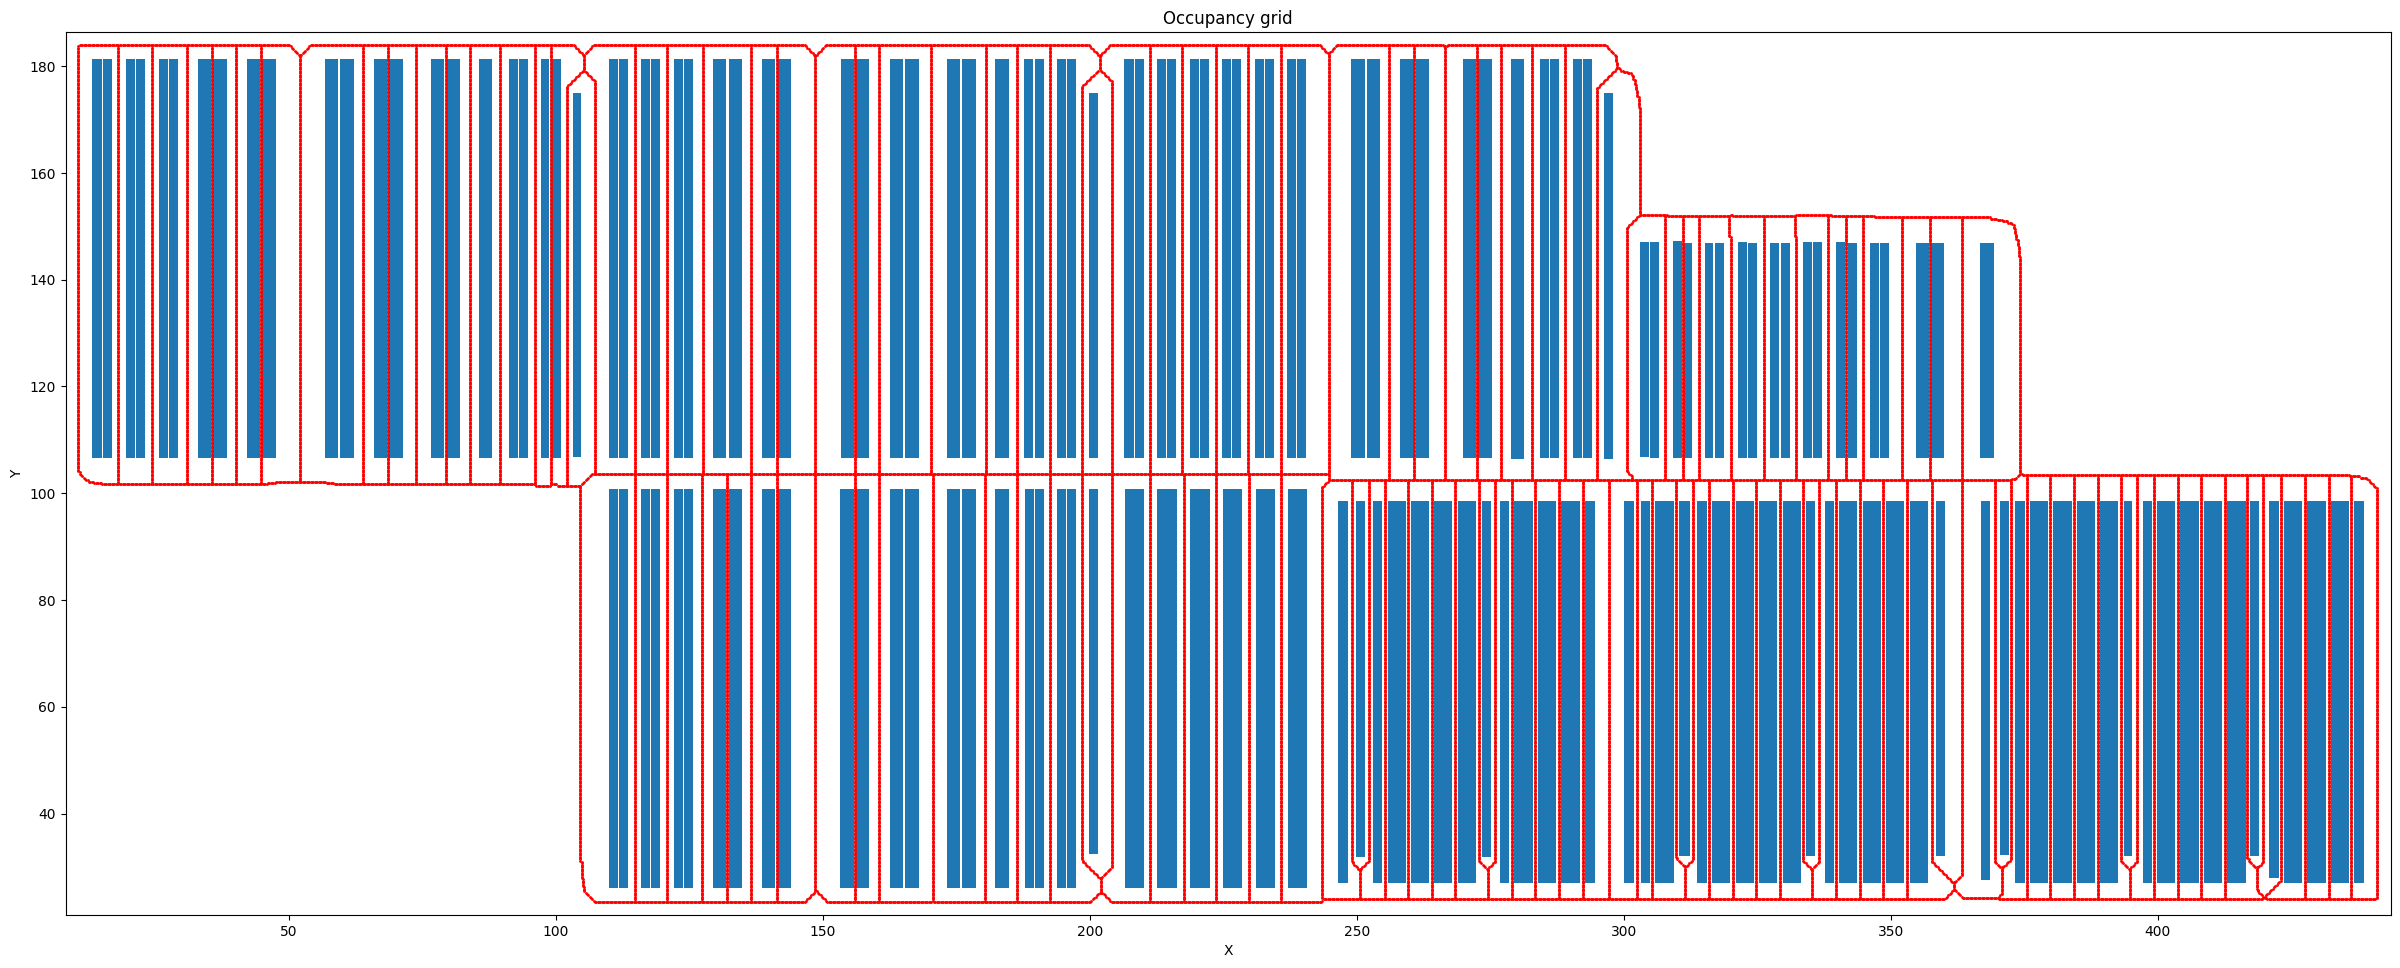

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt

# ---------------------------------------------------------------------------
# 1. Extract raw rackface bounds and directions
# ---------------------------------------------------------------------------
rackface_bounds = {}

for name, loc in warehouse_layout.locations.items():
    rf = loc.rackface
    front = loc.front

    if rf not in rackface_bounds:
        rackface_bounds[rf] = [
            loc.bounds.min.x,
            loc.bounds.min.y,
            loc.bounds.max.x,
            loc.bounds.max.y
        ]
    else:
        b = rackface_bounds[rf]
        b[0] = min(b[0], loc.bounds.min.x)
        b[1] = min(b[1], loc.bounds.min.y)
        b[2] = max(b[2], loc.bounds.max.x)
        b[3] = max(b[3], loc.bounds.max.y)

# ---------------------------------------------------------------------------
# 2. Expand boxes with robot clearance
# ---------------------------------------------------------------------------
clearance = 0.25
expanded = {
    rf: (min_x - clearance, min_y - clearance, max_x + clearance, max_y + clearance)
    for rf, (min_x, min_y, max_x, max_y) in rackface_bounds.items()
}

# ---------------------------------------------------------------------------
# 3. Merge overlapping expanded boxes
# ---------------------------------------------------------------------------
def overlaps(a, b):
    return not (a[2] < b[0] or b[2] < a[0] or a[3] < b[1] or b[3] < a[1])

merged_boxes = []
used = set()
keys = list(expanded.keys())

for i in range(len(keys)):
    if keys[i] in used:
        continue

    ax1, ay1, ax2, ay2 = expanded[keys[i]]
    merged = [ax1, ay1, ax2, ay2]

    for j in range(i + 1, len(keys)):
        if keys[j] in used:
            continue
        bx1, by1, bx2, by2 = expanded[keys[j]]
        if overlaps(merged, (bx1, by1, bx2, by2)):
            merged[0] = min(merged[0], bx1)
            merged[1] = min(merged[1], by1)
            merged[2] = max(merged[2], bx2)
            merged[3] = max(merged[3], by2)
            used.add(keys[j])

    merged_boxes.append(tuple(merged))
    used.add(keys[i])

# ---------------------------------------------------------------------------
# 4. Rasterisation with correct padding and transforms
# ---------------------------------------------------------------------------
resolution = 0.25
padding_m = 5.0

all_x = [b[0] for b in merged_boxes] + [b[2] for b in merged_boxes]
all_y = [b[1] for b in merged_boxes] + [b[3] for b in merged_boxes]

min_x = min(all_x) - padding_m
max_x = max(all_x) + padding_m
min_y = min(all_y) - padding_m
max_y = max(all_y) + padding_m

width = int(np.ceil((max_x - min_x) / resolution))
height = int(np.ceil((max_y - min_y) / resolution))

grid = np.zeros((height, width), dtype=np.uint8)

def world_to_grid(x, y):
    gx = int((x - min_x) / resolution)
    gy = int((y - min_y) / resolution)
    return gx, gy

def grid_to_world(gx, gy):
    return gx * resolution + min_x, gy * resolution + min_y

# Fill obstacles
for (x1, y1, x2, y2) in merged_boxes:
    gx1, gy1 = world_to_grid(x1, y1)
    gx2, gy2 = world_to_grid(x2, y2)
    gx1, gx2 = sorted((gx1, gx2))
    gy1, gy2 = sorted((gy1, gy2))
    grid[gy1:gy2+1, gx1:gx2+1] = 1

# ---------------------------------------------------------------------------
# 5. Distance transform and cutoff
# ---------------------------------------------------------------------------
inv = (grid == 0).astype(np.uint8)
dist = distance_transform_edt(inv) * resolution

threshold_distance = 10.0
grid[dist > threshold_distance] = 1

# ---------------------------------------------------------------------------
# 6. Skeletonise
# ---------------------------------------------------------------------------
free_mask = (grid == 0)
skeleton = skeletonize(free_mask)


# ---------------------------------------------------------------------------
# 7. Plot merged boxes and skeleton
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(30, 30))

# Plot obstacles
for (min_xb, min_yb, max_xb, max_yb) in merged_boxes:
    w = max_xb - min_xb
    h = max_yb - min_yb
    ax.add_patch(
        Rectangle(
            (min_xb, min_yb),
            w,
            h,
            fill=True,
            linewidth=0.8
        )
    )

# Plot skeleton pixels
y_pixels, x_pixels = np.where(skeleton == 1)

# Get the cell centers
xs_world = (x_pixels + 0.5) * resolution + min_x
ys_world = (y_pixels + 0.5) * resolution + min_y

print(len(xs_world))

ax.scatter(xs_world, ys_world, s=1, color="red")

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
ax.set_aspect("equal", adjustable="box")
ax.set_title("Occupancy grid")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()
